In [37]:
import os
import sys

from typing import List, Tuple

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from infovar import ContinuousHandler

sys.path.insert(0, os.path.join("..", ".."))
sys.path.insert(1, os.path.join(".."))

from infobs.plots import Plotter
from orion_util import latex_line, latex_param 

plt.rc("text", usetex=True)
data_dir = os.path.join("..", "data", "continuous")
figures_dir = os.path.join("continuous_images_comparison_linear")

## Configuration of Handler

In [38]:
handler = ContinuousHandler()

handler.set_paths(
    save_path=data_dir
)

## Configuration of Plotter

In [39]:
plotter = Plotter(
    line_formatter=latex_line,
    param_formatter=latex_param
)

latex_comb_lines = lambda ls: plotter.lines_comb_formatter(ls, short=True)
latex_comb_params = lambda ps: plotter.params_comb_formatter(ps)

## Settings

In [40]:
lims = {
    'av': [1e+0, 8e+1],
    'g0': [None, None]
}

In [41]:
params_target = "av"            # Can be "av", "g0" or ["av", "g0"]
params_regime = ["av", "g0"]    # Cannot be modified
lines_list = [["hcn10", "hnc10"], ["13co10", "c18o10"]]#, ["n2hp10", "12cs21"]]

## Formatting

In [42]:
if isinstance(params_target, str):
    params_target = [params_target]
assert isinstance(params_target, List)

if isinstance(lines_list, str):
    lines = [lines_list]
assert isinstance(lines_list, List)

for i, l in enumerate(lines_list):
    if isinstance(l, str):
        lines_list[i] = [l]
    assert isinstance(lines_list[i], List)

## Number of samples

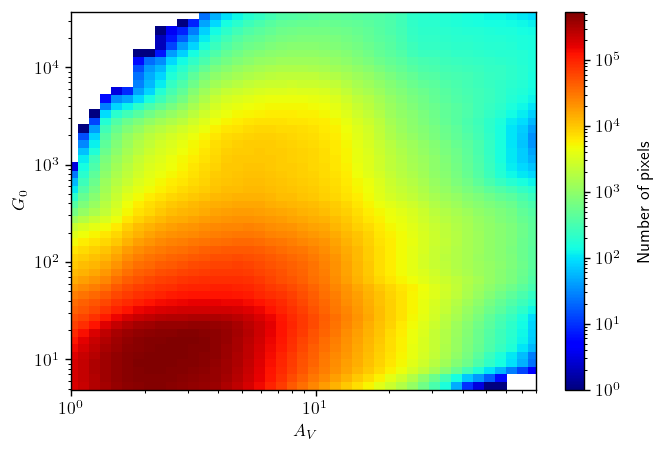

In [43]:
plt.figure(dpi=125)

d = handler.read(
    params_target, lines_list[0], params_regime
)

xticks, yticks = d[f'mi-coords']
mat = d['samples'].T

X, Y = np.meshgrid(xticks, yticks)

np.seterr(divide='ignore')
plt.pcolor(X, Y, mat, cmap="jet", norm=LogNorm(1, None))
cbar = plt.colorbar()
cbar.set_label("Number of pixels", labelpad=10)

plt.xscale('log')
plt.yscale('log')
plt.xlim(lims[params_regime[0]])
plt.ylim(lims[params_regime[1]])

plt.xlabel(f"${latex_param(params_regime[0])}$")
plt.ylabel(f"${latex_param(params_regime[1])}$")

filename = "pixels.png"
plt.savefig(os.path.join(figures_dir, filename))
plt.show()

## Images

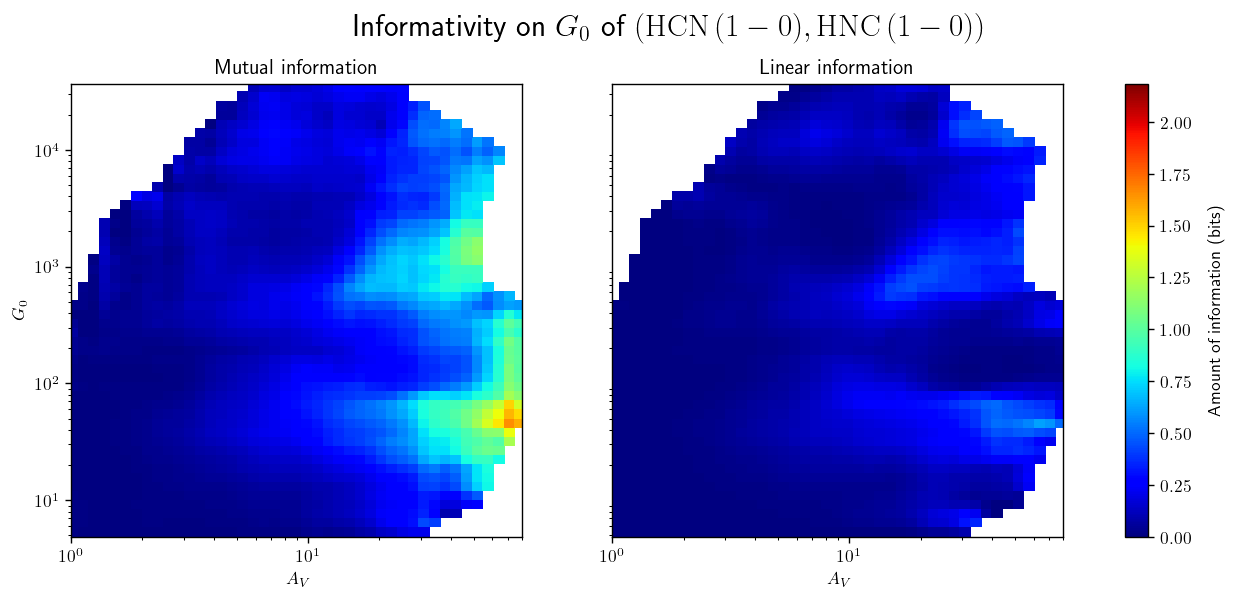

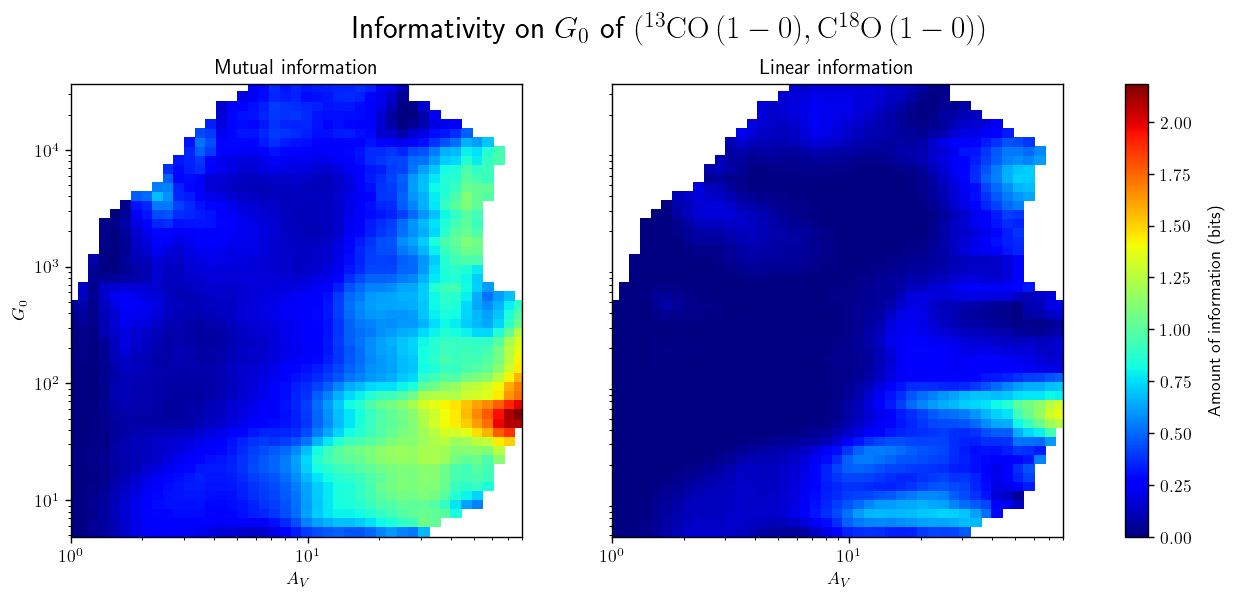

In [44]:
vmin = 0
vmax = 0
for lines in lines_list:

    d = handler.read(
        params_target, lines, params_regime
    )

    vmax = max(vmax, np.nanmax(d[f'mi-data']))
    vmax = max(vmax, np.nanmax(d[f'linearinfo-data']))

for lines in lines_list:

    d = handler.read(
        params_target, lines, params_regime
    )

    xticks, yticks = d[f'mi-coords']
    mat_mi = d['mi-data'].T
    mat_lin = d['linearinfo-data'].T
    
    filename = f"{'_'.join(params_target)}__{'_'.join(lines)}__diff.png"
    fig, (ax1, ax2) = plotter.plot_mi_map_comparison(
        xticks, yticks, mat_mi, mat_lin, diff=False,
        title1="Mutual information", title2="Linear information", titlediff="Nonlinear information",
        vmax=vmax, params=params_target, lines=lines,
        paramx=params_regime[0], paramy=params_regime[1]
    )

    ax1.set_xlim(lims[params_regime[0]]); ax1.set_ylim(lims[params_regime[1]])
    ax2.set_xlim(lims[params_regime[0]]); ax2.set_ylim(lims[params_regime[1]])

    plt.savefig(os.path.join(figures_dir, filename))
    plt.show()

## Differences

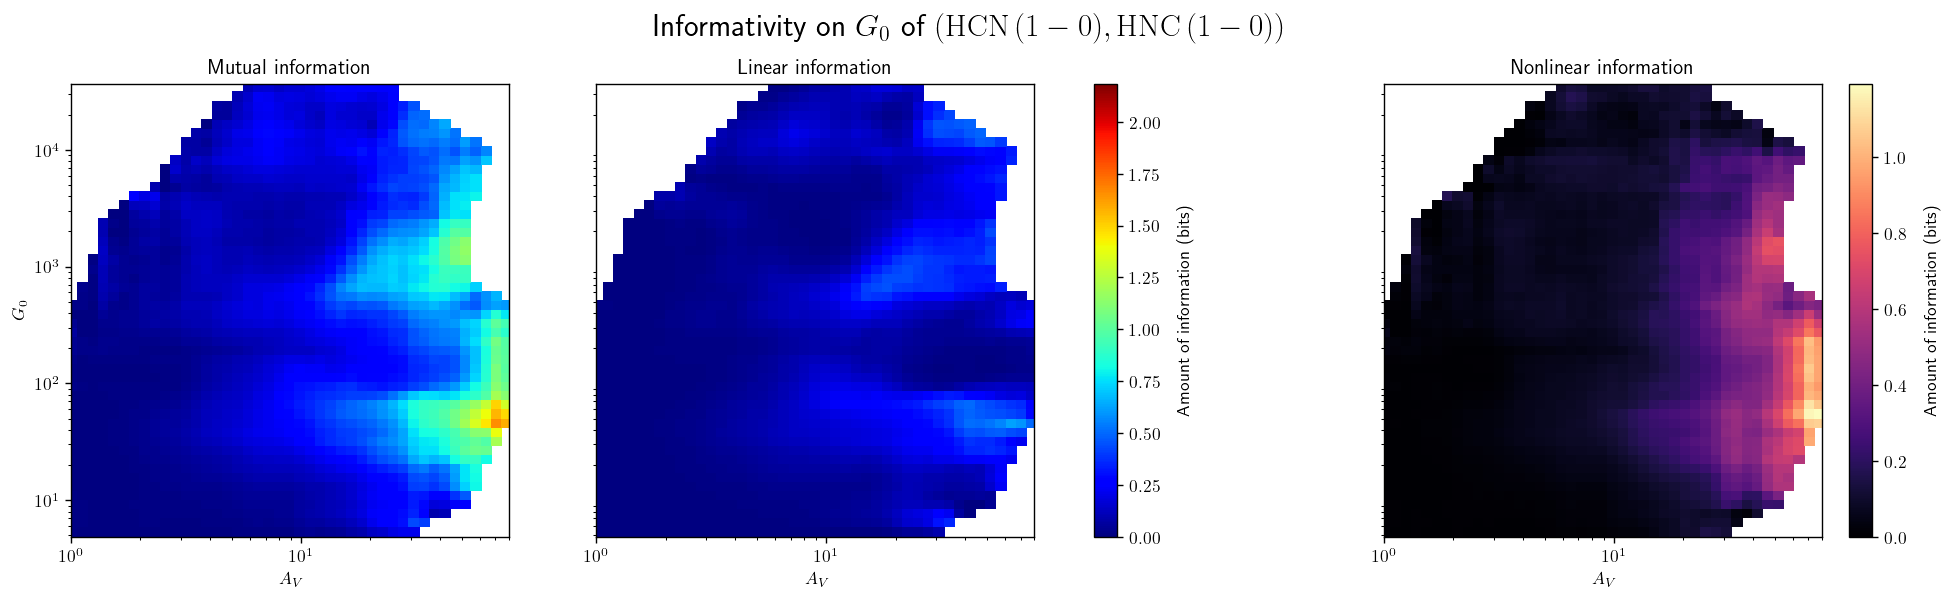

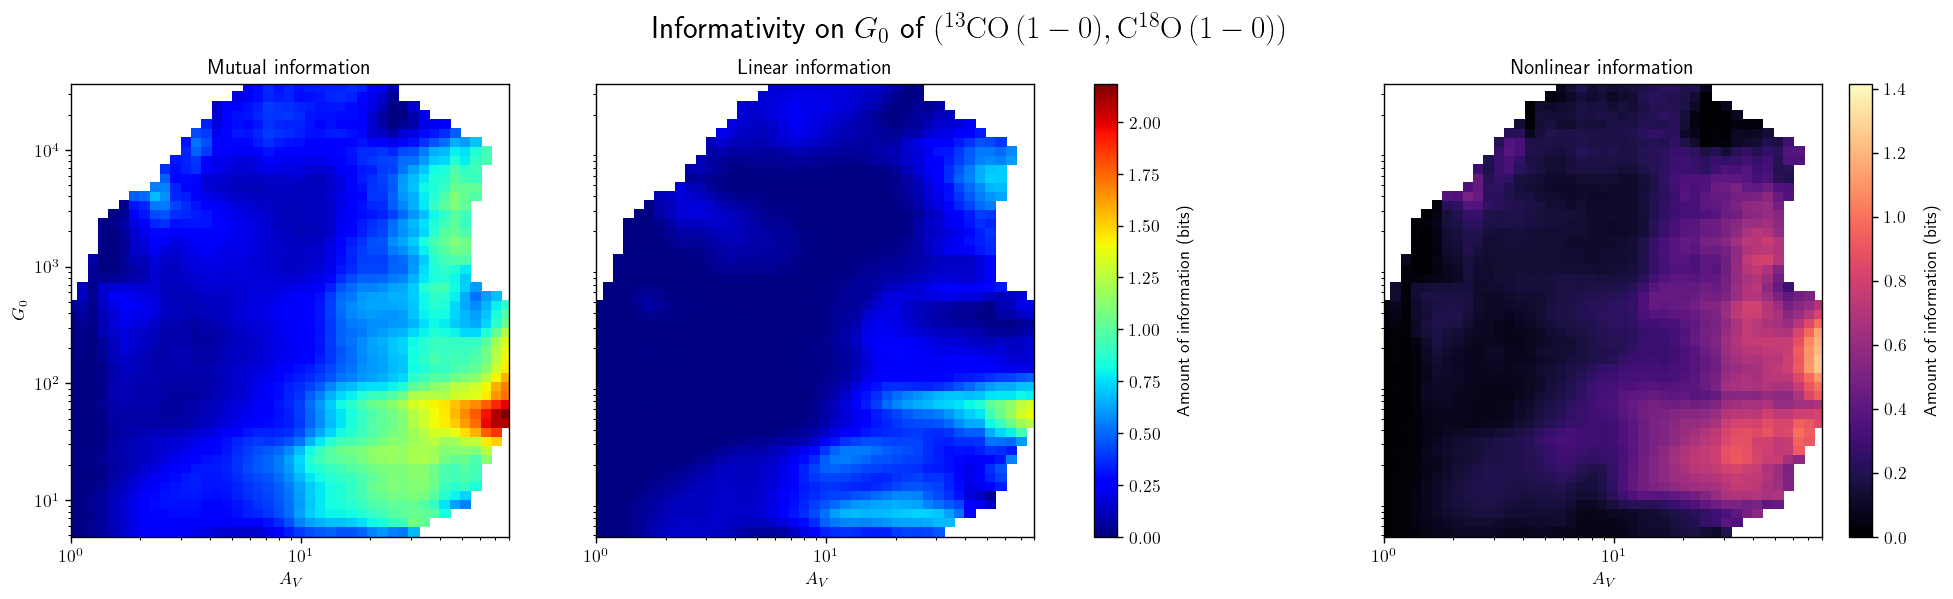

In [45]:
vmax = 0
for lines in lines_list:

    d = handler.read(
        params_target, lines, params_regime
    )

    vmax = max(vmax, np.nanmax(d[f'mi-data']))
    vmax = max(vmax, np.nanmax(d[f'linearinfo-data']))

for lines in lines_list:

    d = handler.read(
        params_target, lines, params_regime
    )

    xticks, yticks = d[f'mi-coords']
    mat_mi = d['mi-data'].T
    mat_lin = d['linearinfo-data'].T
    
    filename = f"{'_'.join(params_target)}__{'_'.join(lines)}__diff.png"
    fig, (ax1, ax2, ax3) = plotter.plot_mi_map_comparison(
        xticks, yticks, mat_mi, mat_lin, diff=True,
        title1="Mutual information", title2="Linear information", titlediff="Nonlinear information",
        vmax=vmax, params=params_target, lines=lines,
        paramx=params_regime[0], paramy=params_regime[1]
    )

    ax1.set_xlim(lims[params_regime[0]]); ax1.set_ylim(lims[params_regime[1]])
    ax2.set_xlim(lims[params_regime[0]]); ax2.set_ylim(lims[params_regime[1]])
    ax3.set_xlim(lims[params_regime[0]]); ax3.set_ylim(lims[params_regime[1]])

    plt.savefig(os.path.join(figures_dir, filename))
    plt.show()

## Map of most informative observables

In [46]:
mat_mis = []
mat_corrs = []

for lines in lines_list:

    d = handler.read(
        params_target, lines, params_regime
    )

    xticks, yticks = d[f'mi-coords']
    mat_mi = d['mi-data'].T
    mat_corr = d['linearinfo-data'].T

    X, Y = np.meshgrid(xticks, yticks)

    mat_mis.append(mat_mi[..., np.newaxis])
    mat_corrs.append(mat_corr[..., np.newaxis])

mat_mis = np.concatenate([np.zeros_like(mat_mis[0])] + mat_mis, axis=-1)
mat_corrs = np.concatenate([np.zeros_like(mat_corrs[0])] + mat_corrs, axis=-1)

In [47]:
res_mi = np.nanargmax(mat_mis, axis=-1)
res_corr = np.nanargmax(mat_corrs, axis=-1)

res_mi = np.where(res_mi == 0, np.nan, res_mi)
res_corr = np.where(res_corr == 0, np.nan, res_corr)

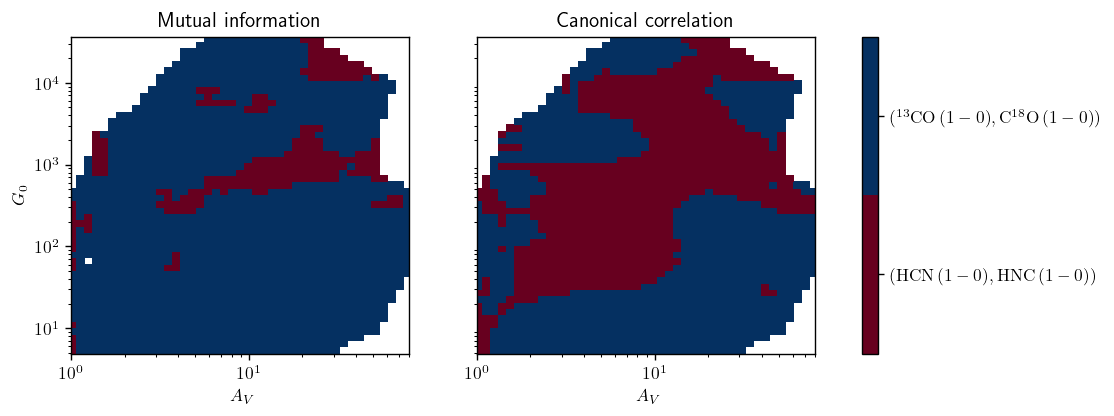

In [48]:
from matplotlib import cm

n = len(lines_list)
cmap = cm.get_cmap('RdBu', n)

plt.figure(figsize=(1.5*6.4, 0.7*4.8), dpi=125)

#

plt.subplot(1, 2, 1)
ax1 = plt.gca()

plt.pcolor(X, Y, res_mi, cmap=cmap, vmin=0.5, vmax=n+0.5)

plt.xscale('log')
plt.yscale('log')

plt.xlim(lims[params_regime[0]])
plt.ylim(lims[params_regime[1]])

plt.xlabel(f"${latex_param(params_regime[0])}$")
plt.ylabel(f"${latex_param(params_regime[1])}$")
plt.title("Mutual information")

#

plt.subplot(1, 2, 2)
ax2 = plt.gca()

plt.pcolor(X, Y, res_corr, cmap=cmap, vmin=0.5, vmax=n+0.5)

cbar = plt.colorbar(ax=[ax1, ax2])
cbar.set_ticks(np.arange(n)+1, labels=[f"${plotter.lines_comb_formatter(c)}$" for c in lines_list])

plt.xscale('log')
plt.yscale('log')

plt.xlim(lims[params_regime[0]])
plt.ylim(lims[params_regime[1]])

plt.xlabel(f"${latex_param(params_regime[0])}$")
plt.yticks([])
plt.title("Canonical correlation")

filename = f"{'_'.join(params_target)}__summary.png"
plt.savefig(os.path.join(figures_dir, filename))
plt.show()